In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score   
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from xgboost import XGBClassifier

In [32]:
%run model_builder.py
%run utils.py

In [33]:
admissions_bachelor = pd.read_csv('datasets/bachelor_data.csv')
admissions_bachelor.set_index('AIS_ID', inplace = True)
admissions_bachelor.dropna(inplace=True)

In [34]:
# attendance removal
admissions_bachelor = admissions_bachelor.loc[:,~admissions_bachelor.columns.str.startswith('attd_')]

In [35]:
# grades removal
subject_cols = ['FYZ_B', 'OOP_B', 'PAM_B', 'PRPR_B', 'ZPRPR2_B', 'TZIV_B', 'ADM_B', 'AJ_B', 'MA_B', 'MIP_B', 'PPI_B']
admissions_bachelor.drop(subject_cols, axis=1, inplace=True)

In [36]:
independent_variable = 'end_type'
y = admissions_bachelor[independent_variable]
X = admissions_bachelor.drop(columns=[independent_variable])

In [37]:
# old index removal
X.drop('Unnamed: 0', axis=1, inplace=True)

In [38]:
attrs_to_drop = ['study_programme',  'VŠP_štúdium', 'graduation_year'] #

X.drop(attrs_to_drop, axis=1, inplace=True)

In [39]:
# Parameters doc
# https://xgboost.readthedocs.io/en/latest/parameter.html

clf = XGBClassifier()
cv_params = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)],
    'n_estimators': list(range(11, 100, 10)),
}

In [40]:
model_xgboost = ModelBuilder(clf, X, y)\
    .test_train_split(0.2)\
    .tune_hyperparameters(cv_params)\
    .train_model_with_optimization()\
    .predict()\
    .build()

Fitting optimization...
Fitting 10 folds for each of 540 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:  1.2min finished


In [41]:
model_xgboost.optimization.best_params_

{'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 31}

In [42]:
print(accuracy_score(model_xgboost.test_y, model_xgboost.pred_y))

0.8156996587030717


In [43]:
print(precision_score(model_xgboost.test_y, model_xgboost.pred_y, average='macro'))
print(recall_score(model_xgboost.test_y, model_xgboost.pred_y, average='macro'))
print(f1_score(model_xgboost.test_y, model_xgboost.pred_y, average='macro'))

0.8311422109132033
0.8443840047044987
0.8150771388499298


In [44]:
print(precision_score(model_xgboost.test_y, model_xgboost.pred_y, average='micro'))
print(recall_score(model_xgboost.test_y, model_xgboost.pred_y, average='micro'))
print(f1_score(model_xgboost.test_y, model_xgboost.pred_y, average='micro'))

0.8156996587030717
0.8156996587030717
0.8156996587030716


In [45]:
make_stratified_k_fold(10, XGBClassifier(**model_xgboost.optimization.best_params_), X, y)

0.853 & 0.851 & 0.850 & 0.850 \\
0.758 & 0.755 & 0.755 & 0.755 \\
0.807 & 0.797 & 0.796 & 0.794 \\
0.743 & 0.719 & 0.719 & 0.712 \\
0.829 & 0.801 & 0.801 & 0.797 \\
0.799 & 0.781 & 0.781 & 0.777 \\
0.774 & 0.753 & 0.753 & 0.749 \\
0.743 & 0.740 & 0.740 & 0.739 \\
0.757 & 0.747 & 0.747 & 0.744 \\
0.789 & 0.781 & 0.781 & 0.779 \\
0.785 & 0.772 & 0.772 & 0.770 \\


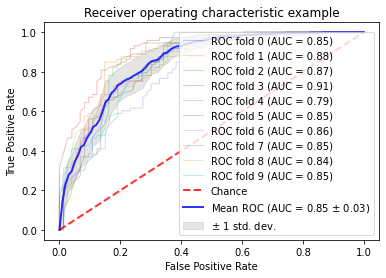

In [46]:
create_roc_curve(10, XGBClassifier(**model_xgboost.optimization.best_params_), X, y)

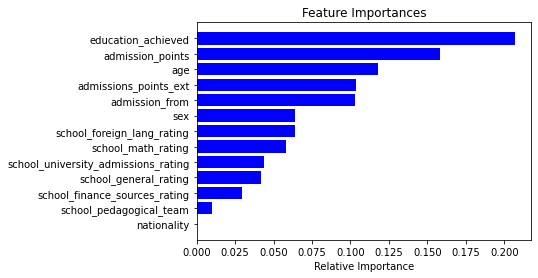

In [47]:
features = model_xgboost.train_X.columns
importances = model_xgboost.clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [48]:
from xgboost import plot_tree

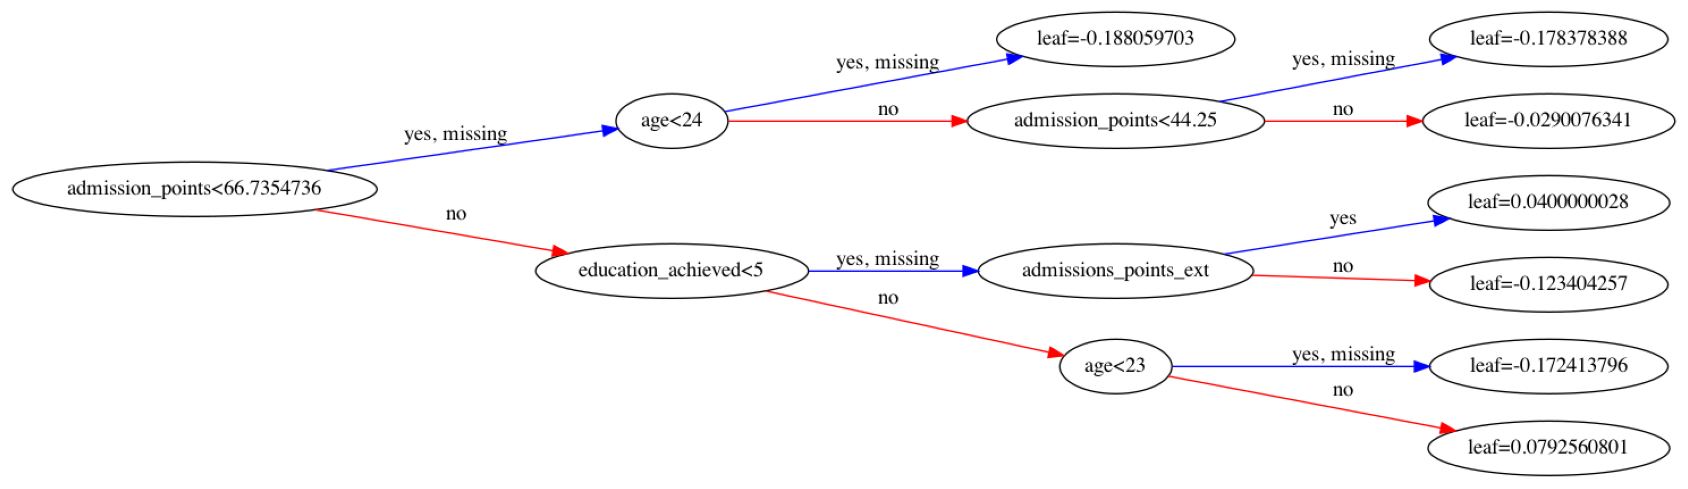

In [49]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model_xgboost.clf, rankdir='LR', num_trees=0, ax=ax)
plt.show()

# SHAP

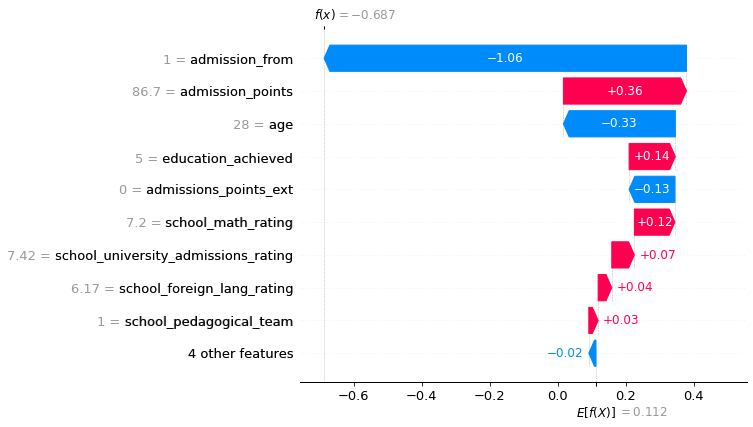

In [58]:
import shap

# train an XGBoost model

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model_xgboost.clf)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

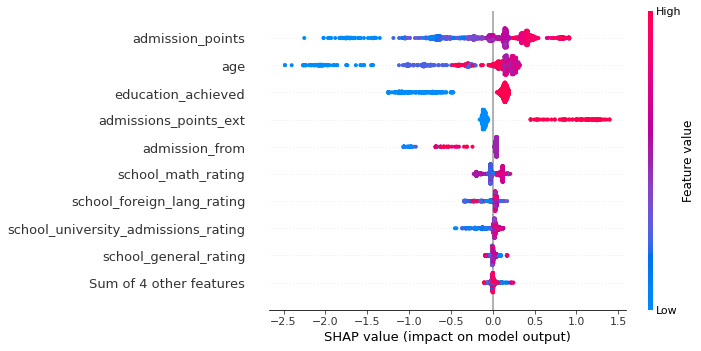

In [59]:
shap.plots.beeswarm(shap_values)


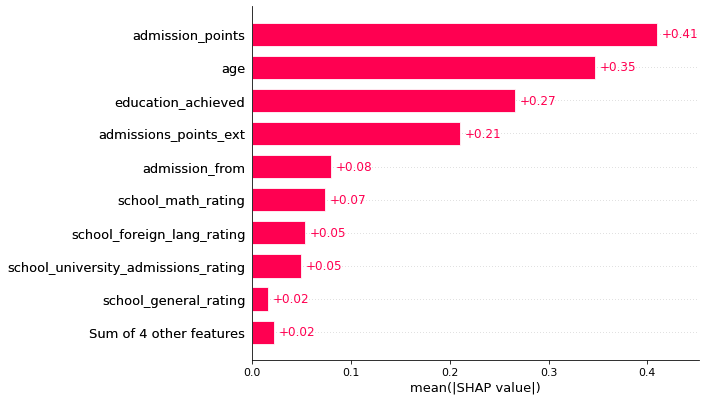

In [60]:
shap.plots.bar(shap_values.abs.mean(0))


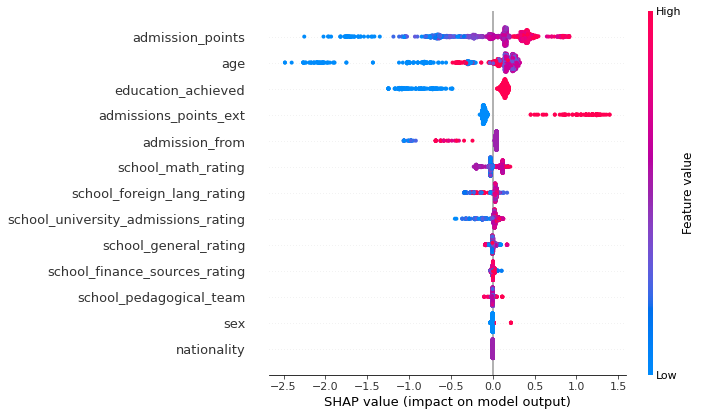

In [64]:
shap.summary_plot(shap_values, features=model_xgboost.train_X)